# A06 Q2: Batch Normalization

In [1]:
import numpy as np
import torch
import torch.nn as nn
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset

In [2]:
# Make a PyTorch wrapper for our UClasses dataset
class UClasses(torch.utils.data.Dataset):
    def __init__(self, n=300):
        super().__init__()
        np_ds = utils.UClasses(n=n, binary=False)  # heavy lifting done by NumPy code
        self.x = torch.tensor(np_ds.inputs(), dtype=torch.float32)
        self.t = torch.argmax(torch.tensor(np_ds.targets()), axis=1, keepdim=False)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.t[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.t
            
    def plot(self, labels=None, *args, **kwargs): 
        if labels is None:
            labels = self.t
        colour_options = ['y', 'r', 'g', 'b', 'k']
        if len(labels.size())>1 and len(labels[0])>1:
            # one-hot labels
            cidx = torch.argmax(labels, axis=1)
        else:
            # binary labels
            cidx = (labels>0.5).type(torch.int)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(self.x[:,0].detach(), self.x[:,1].detach(), color=colours, marker='.')
        plt.axis('equal');

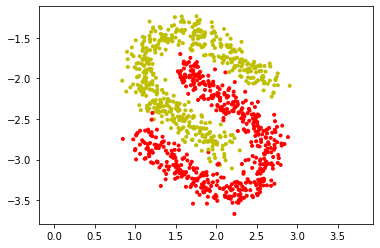

In [3]:
train = UClasses(n=1000)
train.plot()

In [4]:
train.targets()[0]

tensor(1)

In [5]:
train_dl = torch.utils.data.DataLoader(train, batch_size=200, shuffle=True)

# A. `BatchNorm` Class

In [6]:
class BatchNorm(nn.Module):
    '''
     lyr = BatchNorm(eps=0.001)
     
     Creates a PyTorch layer (Module) that implements batch normalization, so
     that its outputs are remapped. For each node in the layer, the output for the
     batch is normalized so that it is zero-mean and approximately unit-variance.
     
     Inputs:
      eps     stability parameter, to avoid division by zero
             
     Usage:
      lyr = BatchNorm(eps=0.001)
      y = lyr(x)    # x is a batch (tensor), with one sample in each row
                    # y is the same shape as x
    '''
    def __init__(self, eps=0.001):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        mean = torch.mean(x, dim=0)
        sd = torch.std(x, dim=0)
        y = (x - mean) / torch.sqrt(sd ** 2 + self.eps)
        return y

# B. Demonstrate `BatchNorm`

In [7]:
bn = BatchNorm()
batch = next(iter(train_dl))[0]
orig_mean = torch.mean(batch, dim=0)
orig_sd = torch.std(batch, dim=0)
y = bn.forward(batch)
norm_mean = torch.mean(y, dim=0)
norm_sd = torch.std(y, dim=0)

print('Original inputs:')
print(f'Mean: {orig_mean}')
print(f'Std: {orig_sd}')

print('\nNormalized inputs:')
print(f'Mean: {norm_mean}')
print(f'Std: {norm_sd}')

Original inputs:
Mean: tensor([ 1.8633, -2.4074])
Std: tensor([0.5208, 0.5732])

Normalized inputs:
Mean: tensor([-4.4107e-08,  9.5367e-09])
Std: tensor([0.9982, 0.9985])


# Network base class, `NNBase`

In [8]:
# This network base class saves us from having to duplicate the learn function.

class NNBase(nn.Module):
    '''
     You should not instantiate this class directly. 
     Base class for other simple neural network classes.
     eg.
       class MyDerivedNN(NNBase):
          ...
    '''
    def __init__(self):
        super().__init__()
        self.losses = []
        self.loss_fcn = None  # Should be overridden in derived class
        
    def forward(self, x):
        return x
        
    def learn(self, dl, epochs=10, lr=0.1, plot=True):
        '''
         net.learn(dl, epochs=10, lr=0.1, plot=True)
         
         Performs SGD on the neural network.
         Inputs:
          dl      DataLoader object (PyTorch)
          epochs  number of epochs to perform
          lr      learning rate
          plot    whether or not to plot the learning curve
        '''
        optim = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x,t in dl:
                y = self(x)
                loss = self.loss_fcn(y, t.float())
                optim.zero_grad()
                loss.backward()
                optim.step()
                total_loss += loss.item()
            self.losses.append(total_loss/len(dl))
        if plot:
            plt.figure(figsize=(4,4))
            plt.plot(self.losses);

# C. Compare learning performance

## Create two network classes

In [9]:
# NormalNet
# Create a simple neural network that does NOT use batchnorm.
# You should use NNBase as the base class.
class NormalNet(NNBase):
    def __init__(self, loss_fcn):
        super().__init__()
        self.loss_fcn = loss_fcn
        self.network = nn.Sequential(
            nn.Linear(2, 6),
            nn.LeakyReLU(),
            nn.Linear(6, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return torch.squeeze(self.network(x))

In [10]:
# BNNet
# Create a simple neural network that DOES use batchnorm after each
# layer (except the output layer).
# You should use NNBase as the base class.
# Apply batchnorm between the activation function and the connections
# to the next layer.
class BNNet(NNBase):
    def __init__(self, loss_fcn):
        super().__init__()
        self.loss_fcn = loss_fcn
        self.bn_layer = BatchNorm()
        self.network = nn.Sequential(
            nn.Linear(2, 6),
            nn.LeakyReLU(),
            self.bn_layer,
            nn.Linear(6, 8),
            nn.LeakyReLU(),
            self.bn_layer,
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return torch.squeeze(self.network(x))

## Experiments
Let's compare the learning curves for the following cases:
1. Normal NN (no batchnorm)
3. Batchnorm

In [11]:
# Code to run experiments
experiments = 10
loss_fcn = nn.BCELoss()
loss_a = []
loss_b = []

for i in range(experiments):
    a = NormalNet(loss_fcn)
    data_a = UClasses(n=1000)
    dl_a = torch.utils.data.DataLoader(data_a, batch_size=200, shuffle=True)
    a.learn(dl_a, epochs=200, plot=False)
    loss_a.append(a.losses)
    
    b = BNNet(loss_fcn)
    data_b = UClasses(n=1000)
    dl_b = torch.utils.data.DataLoader(data_b, batch_size=200, shuffle=True)
    b.learn(dl_b, epochs=200, plot=False)
    loss_b.append(b.losses)

100%|██████████| 200/200 [00:02<00:00, 91.53it/s] 


## Results

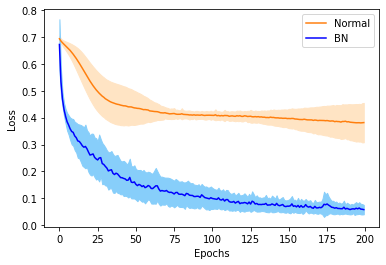

In [12]:
# Code to plot the results of the trials
loss_a = np.array(loss_a)
loss_b = np.array(loss_b)
mean_a = np.mean(loss_a, axis=0)
mean_b = np.mean(loss_b, axis=0)
sd_a = np.std(loss_a, axis=0)
sd_b = np.std(loss_b, axis=0)
x = range(200)

plt.plot(mean_a, label="Normal", color="tab:orange")
plt.plot(mean_b, label="BN", color="blue")
plt.fill_between(x=x, y1=mean_a-sd_a, y2=mean_a+sd_a, color="bisque")
plt.fill_between(x=x, y1=mean_b-sd_b, y2=mean_b+sd_b, color="lightskyblue")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()